In [10]:
%matplotlib inline

import sys, platform, os
import scipy.fftpack as fft
from scipy.integrate import quad, romberg
from scipy.special import spherical_jn as jn
from scipy.interpolate import interp1d,splev,splrep
from matplotlib import pyplot as plt
import numpy as np
import math
from scipy.interpolate import InterpolatedUnivariateSpline
from timeit import default_timer as timer

sys.path.append('/Volumes/Data/Documents/Git/IR_resum/scripts/')
from wnw_EH import EHFits
import wnw_Gfilter as Gfilter
import wnw_BSpline as BSpline
import wnw_dst as dst


### CAMB
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import camb
from camb import model, initialpower
print('CAMB version: %s '%camb.__version__)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.figsize'] = [5.5, 4]

plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams["axes.labelsize"] = 12
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 0.8
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 0.6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.major.width'] = 0.8
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = 0.6
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = 'on'
plt.rcParams['ytick.right'] = 'on'


CAMB version: 1.3.6 


# 1. Set the parmaeters of CAMB 

In [11]:
#the values of the parameter below are from the fit to matter power spectrum of Flagship. 
#when I use these values, however, my value of sigma8 is about 1.5% off from values listed
#on HOS slides from 2023-05-08  (sigma8 = 0.83 vs mine sigma8 = 0.818). 
H0     = 67
h = H0/100
ombh2 = 0.049*h**2.
omch2 = 0.27*h**2.
omm = (ombh2+omch2)/h**2
ns    = 0.96
As = 2.0942702791129642e-09

pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2,  omk=0, tau=0.055,mnu=0.)
pars.InitPower.set_params(As=As, ns=ns, r=0, pivot_scalar = 0.05)
pars.set_matter_power(redshifts=[0.,4.0], kmax=30.0)
results = camb.get_results(pars)
print("num_massive_nu:", pars.num_nu_massive)
print("num_massless_nu:", pars.num_nu_massless)

# Compute the sigma8: note that get_sigma8() function returns 
# an array of values, in order of increasing time (decreasing redshift)
sigma8 = np.array(results.get_sigma8())   
print(sigma8)

# ka, pka       = np.loadtxt('/Users/azadeh/Desktop/IR_resummation/codes/Matteo/SplitW_NW/input/powL2000_gaussian_085_otherconvention_good.dat',unpack=True)
ka, pka       = np.loadtxt('/Volumes/Data/Documents/Git/IR_resum/data/flagship_linear_cb_hr_matterpower_z0p0.dat',unpack=True)
logpka        = np.log10(pka)
logka         = np.log10(ka)
logpka_interp = InterpolatedUnivariateSpline(logka,logpka,k=3)



Note: redshifts have been re-sorted (earliest first)
num_massive_nu: 0
num_massless_nu: 3.046
[0.20874627 0.82668229]


# 2. Compute matter power spectrum

In [12]:

PK_NL = camb.get_matter_power_interpolator(pars, nonlinear=True,hubble_units=True,k_hunit=True,zmax=1100,log_interp=True,k_per_logint=True,extrap_kmax=1000)
PK_L = camb.get_matter_power_interpolator(pars, nonlinear=False,hubble_units=True,k_hunit=True,zmax=1100,log_interp=True,k_per_logint=True,extrap_kmax=1000)

### Get the transfer functions, kh = 1, Transfer_cdm = 2, Transfer_b = 3, Transfer_tot = 7
# trans = data.get_matter_transfer_data()
# kh = trans.transfer_data[0,:,0]
# delta_cdm = trans.transfer_data[model.Transfer_cdm-1,:,0]
# delta_b = trans.transfer_data[model.Transfer_b-1,:,0]
# delta_tot = trans.transfer_data[model.Transfer_tot-1,:,0]

# print model.Transfer_cdm, model.Transfer_b, model.Transfer_tot
# Tcdm = delta_cdm/max(delta_cdm)
# Tb = delta_b/max(delta_b)
# Ttot = delta_tot/max(delta_tot)

# plt.loglog(kh,Tcdm/Ttot,label="cdm")
# plt.loglog(kh,Tb/Ttot,label="b")
# #plt.loglog(kh,Ttot,label="tot")
# # plt.xlim(1.e-3,1.)
# # plt.ylim(1.e-2,1.)
# plt.legend()
# plt.show()

# 3. Eisentein and Hu fit (astro-ph/9709112), load the functions from EH_fit module.

Plot the EH total matter, cdm, baryons and zero baryon transfer functions, the power spectrum and wiggle-only contribution to power spectrum

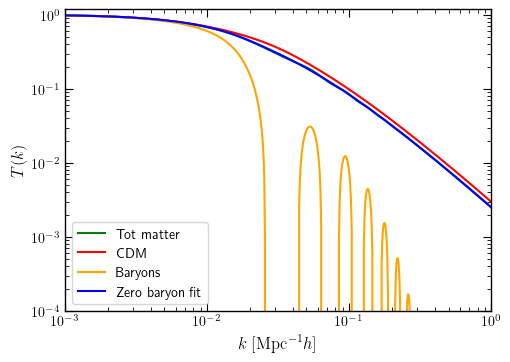

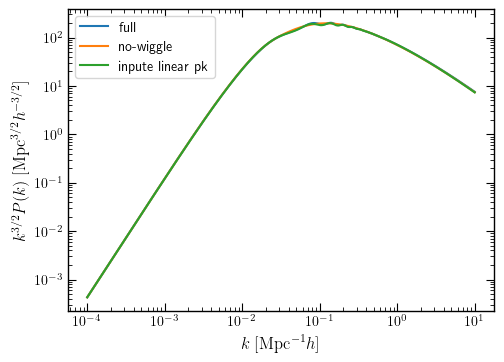

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


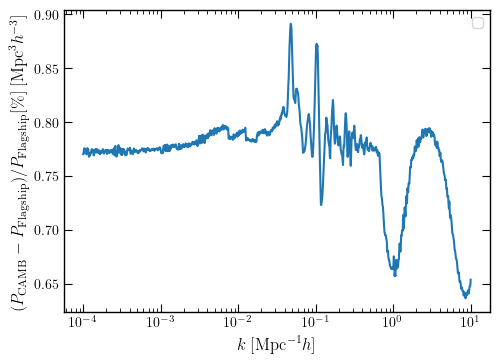

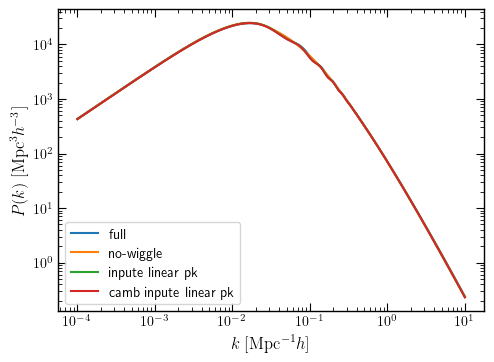

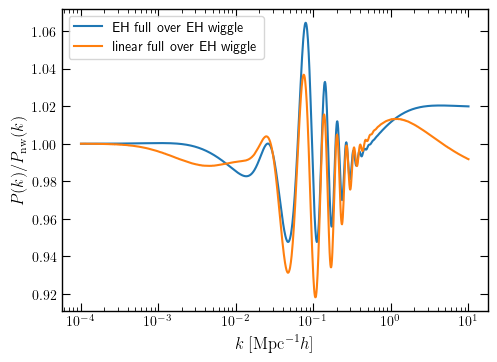

In [13]:
logks = np.linspace(-4.,1.,1000)
ks = (10.**logks)  ##ks in units of h/Mpc
kin = ks[0]
# pkin = PK_L.P(0,kin)
pkin = 10.**logpka_interp(np.log10(kin))
pk = 10.**logpka_interp(np.log10(ks))


# Set the values of the cosmological parameters that you would like to use for EH fit. 
# These should correspond to the values used in generating the power spectrum that you pass
# to EH function. 
h     = 0.67
H0     = 67
ombh2 = 0.049*h**2.
omch2 = 0.27*h**2.
omm = (ombh2+omch2)/h**2
ns    = 0.96
As = 2.0942702791129642e-09


EH = EHFits(h,ombh2,omch2,ns)

plt.loglog(ks, EH.T(ks),"green", label="Tot matter")
plt.loglog(ks, EH.Tc(ks),"red", label="CDM")
plt.loglog(ks, EH.Tb(ks),"orange", label = "Baryons")
plt.loglog(ks, EH.T0(ks),"blue",label="Zero baryon fit")
plt.xlabel('$k \; [\mathrm{Mpc}^{-1} h]$')
plt.ylabel('$T(k)$')
plt.xlim(1.e-3,1.)
plt.ylim(1e-4,1.2)
plt.legend()
plt.show()

plt.loglog(ks,ks**(3./2.)*EH.EH_tot(ks,kin,pkin), label="full")
plt.loglog(ks,ks**(3./2.)*EH.EH_nw(ks,kin,pkin),label="no-wiggle")
plt.loglog(ks,ks**(3./2.)*pk, label = "inpute linear pk")
# plt.loglog(ks,(ks)**(3./2.)*PK_L.P(0,ks), label = "inpute linear pk")
plt.xlabel('$k \; [\mathrm{Mpc}^{-1} h]$')
plt.ylabel('$k^{3/2}P(k)\; [\mathrm{Mpc}^{3/2} h^{-3/2}]$')
plt.legend()
plt.show()

# check how well the camb-computed Pm_linear matches the linear power spectrum from Flagship
plt.semilogx(ks,(pk-PK_L.P(0,ks))/pk *100)
plt.xlabel(r'$k \; [\mathrm{Mpc}^{-1} h]$')
plt.ylabel(r'$(P_{\rm CAMB} - P_{\rm Flagship})/P_{\rm Flagship} [\%]\; [\mathrm{Mpc}^3 h^{-3}]$')
plt.legend()
plt.savefig('camb_flagship.png', facecolor='white')
plt.show()

plt.loglog(ks,EH.EH_tot(ks,kin,pkin), label="full")
plt.loglog(ks,EH.EH_nw(ks,kin,pkin),label="no-wiggle")
plt.loglog(ks,pk, label = "inpute linear pk")
plt.loglog(ks,PK_L.P(0,ks), label = "camb inpute linear pk")
plt.xlabel(r'$k \; [\mathrm{Mpc}^{-1} h]$')
plt.ylabel(r'$P(k)\; [\mathrm{Mpc}^3 h^{-3}]$')
plt.legend()
plt.show()

plt.semilogx(ks,EH.EH_tot(ks,kin,pkin)/EH.EH_nw(ks,kin,pkin),label="EH full over EH wiggle")
plt.semilogx(ks,pk/EH.EH_nw(ks,kin,pkin),label = "linear full over EH wiggle")
#plt.semilogx(ks,PK_L.P(0,ks)/EH.EH_PS_nw(ks,kin,pkin),label = "linear full, EH wiggle")
plt.xlabel('$k \; [\mathrm{Mpc}^{-1} h]$')
plt.ylabel('$P(k)/P_\mathrm{nw}(k)$')
plt.legend()
plt.show()

# plt.semilogx(ks,EH.EH_tot(ks,kin,PK_L.P(0,ks))/EH.EH_nw(ks,kin,PK_L.P(0,ks)),label="EH full over EH wiggle")
# plt.semilogx(ks,PK_L.P(0,ks)/EH.EH_nw(ks,kin,PK_L.P(0,kin)),label = "linear full over EH wiggle")
# plt.semilogx(ks,pk/EH.EH_nw(ks,kin,pkin),label = "linear full, EH wiggle")
# plt.xlabel('$k \; [\mathrm{Mpc}^{-1} h]$')
# plt.ylabel('$P(k)/P_\mathrm{nw}(k)$')
# plt.ylim(0.9,1.1)
# plt.legend()
# plt.show()



35.10879533935844 0.8267241975775297
ok


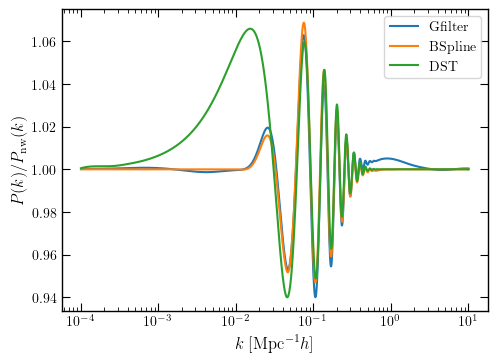

In [14]:
vec_pk_nw   = np.vectorize(Gfilter.pk_Gfilter_nw)
pnw_Gfilter = vec_pk_nw(ks, kin, PK_L, EH)
pw_Gfilter  = PK_L.P(0,ks) - pnw_Gfilter

class BsplineVars:
    def __init__(self, k_input, kmin_fit, kmax_fit, Sdeg, Sknot):
        self.kk      = k_input
        self.kfmin   = kmin_fit
        self.kfmax   = kmax_fit
        self.deg     = Sdeg
        self.knot    = Sknot
interp      = BsplineVars(ks, 10.**(-2.), 10.**(0.06),4,0)
pnw_Bspline = BSpline.pk_Bspline_nw(ks, interp, PK_L, EH)
pw_Bspline  = PK_L.P(0,ks) - pnw_Bspline

pnw_dst = dst.pk_dst_nw(ks, PK_L)
pw_dst  = PK_L.P(0,ks) - pnw_dst

plt.semilogx(ks,PK_L.P(0,ks)/pnw_Gfilter,label=r'${\rm Gfilter}$')
plt.semilogx(ks,PK_L.P(0,ks)/pnw_Bspline,label=r'${\rm BSpline}$')
plt.semilogx(ks,PK_L.P(0,ks)/pnw_dst,label=r'${\rm DST}$')
plt.xlabel('$k \; [\mathrm{Mpc}^{-1} h]$')
plt.ylabel('$P(k)/P_\mathrm{nw}(k)$')
plt.legend()
plt.show()